<a href="https://colab.research.google.com/github/Maryam1278/Holy-Quran-Speech-Recognition-System-/blob/main/PCA8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# Check audio folder
audio_path = "/content/drive/MyDrive/dataset colab/All surah audio"
csv_path = "/content/drive/MyDrive/dataset colab/Allsurah.csv"

print("Audio Folder Exists:", os.path.exists(audio_path))
print("CSV File Exists:", os.path.exists(csv_path))

Audio Folder Exists: True
CSV File Exists: True


In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [ ]:

# Function to extract features from audio files
def extract_features(y, sr):
    try:
        # MFCCs
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        # Spectral Contrast
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        # Mel Spectrogram
        mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40).T, axis=0)
        # Chroma Features
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        features = np.concatenate((mfccs, spectral_contrast, mel_spectrogram, chroma))
        return features
    except Exception as e:
        print(f"Error extracting features: {str(e)}")
        return np.array([])

# Paths for Google Colab
audio_folder = "/content/drive/MyDrive/dataset colab/All surah audio"
csv_path = "/content/drive/MyDrive/dataset colab/Allsurah.csv"



In [ ]:
# Load the CSV file for the Holy Qur'an audio data
df = pd.read_csv(csv_path)

# Prepare data
features, labels = [], []

for index, row in df.iterrows():
    file_name = os.path.join(audio_folder, f"{row['name']}.wav")
    class_label = row['label']

    if os.path.exists(file_name):
        y, sr = librosa.load(file_name, sr=None)
        data = extract_features(y, sr)
        if len(data) > 0:
            features.append(data)
            labels.append(class_label)

if len(labels) == 0:
    raise ValueError("No labels found. Please check your data.")



In [ ]:
# Encode the classification labels
le = LabelEncoder()
labels_encoded = to_categorical(le.fit_transform(labels))

X = np.array(features)
y = np.array(labels_encoded)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, np.argmax(y, axis=1))

# Convert resampled labels back to one-hot encoding
y_resampled = to_categorical(y_resampled, num_classes=y.shape[1])

# Normalize the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Dimensionality Reduction (PCA)
pca = PCA(n_components=50)
X_resampled = pca.fit_transform(X_resampled)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 117s 66ms/step - accuracy: 0.0584 - loss: 3.3097 - val_accuracy: 0.1114 - val_loss: 2.9854
Epoch 2/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 136s 63ms/step - accuracy: 0.1135 - loss: 2.9759 - val_accuracy: 0.1894 - val_loss: 2.7920
Epoch 3/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 105s 65ms/step - accuracy: 0.1731 - loss: 2.8189 - val_accuracy: 0.2446 - val_loss: 2.6120
Epoch 4/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 142s 65ms/step - accuracy: 0.2265 - loss: 2.6450 - val_accuracy: 0.3229 - val_loss: 2.4209
Epoch 5/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 144s 66ms/step - accuracy: 0.2759 - loss: 2.5088 - val_accuracy: 0.4084 - val_loss: 2.1155
Epoch 6/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 136s 63ms/step - accuracy: 0.3207 - loss: 2.3508 - val_accuracy: 0.4220 - val_loss: 2.1282
Epoch 7/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 147s 66ms/step - accuracy: 0.3649 - loss: 2.2655 - val_accuracy: 0.4624 - val_loss: 1.9488
Epoch 8/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 105s 65ms/step - accuracy: 

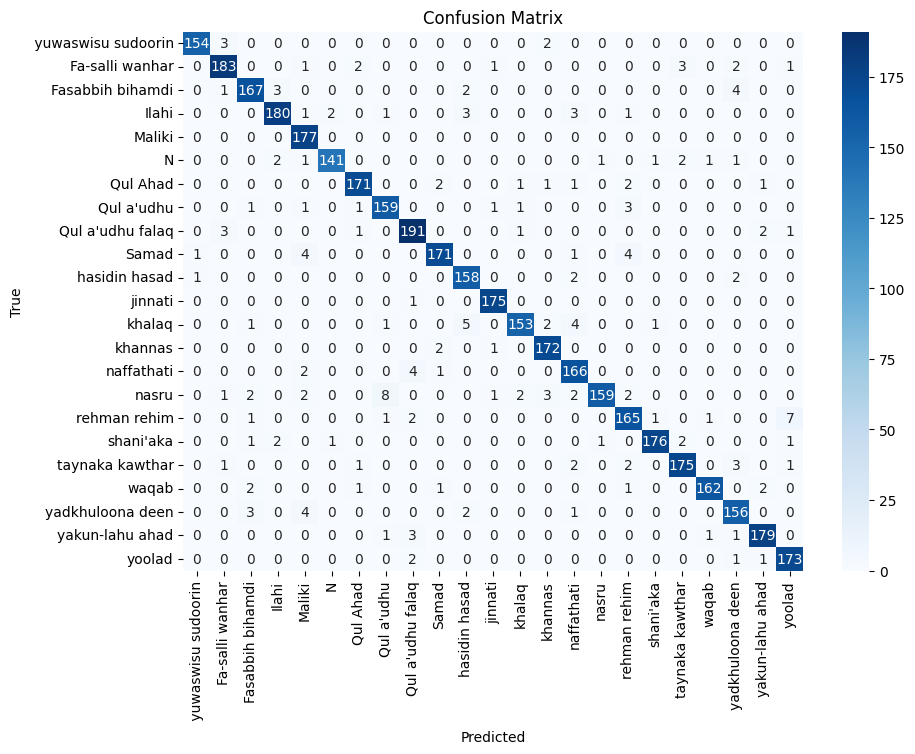

In [ ]:
# Reshape for LSTM input (samples, timesteps, features)
X_resampled = np.expand_dims(X_resampled, axis=2)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.8),
    LSTM(128, kernel_regularizer=l2(0.01)),
    Dropout(0.8),
    Dense(23, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Cross-validation (Stratified KFold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=8, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')

# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
report = classification_report(y_true, y_pred_classes, target_names=le.classes_)
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import os
import tensorflow as tf

# Assuming your model is already created and trained, save the model in Keras format
keras_model_path = '/content/audio_classification_modelPC8.keras'
model.save(keras_model_path)

# TFLite Conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = '/content/audio_classification_modelPC8.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Check if the TFLite model was saved correctly
if os.path.exists(tflite_model_path):
    print(f"✅ TFLite model saved successfully at {tflite_model_path}")
else:
    print(f"❌ Error: TFLite model was not saved. Check the conversion process.")


Saved artifact at '/tmp/tmps7co9vow'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 23), dtype=tf.float32, name=None)
Captures:
  137058700312400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137058700310096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137058700304336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137058700305104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137058700309328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137058700308560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137058700305488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137058700307024: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite model saved successfully at /content/audio_classification_modelPC8.tflite
